# Single Object Localization

The notebook illustrates how the SquiDS package can help to create and test a single object localization model.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of the SquiDS package.**

In [2]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw, ImageFont
import tensorflow as tf
import numpy as np

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [2]:
create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365,
    image_capacity=1,
    verbose=True)
create_tfrecords(verbose=True)

100%|██████████| 999/999 [00:00<00:00, 1217.78it/s]


Explore few samples from the generated dataset.

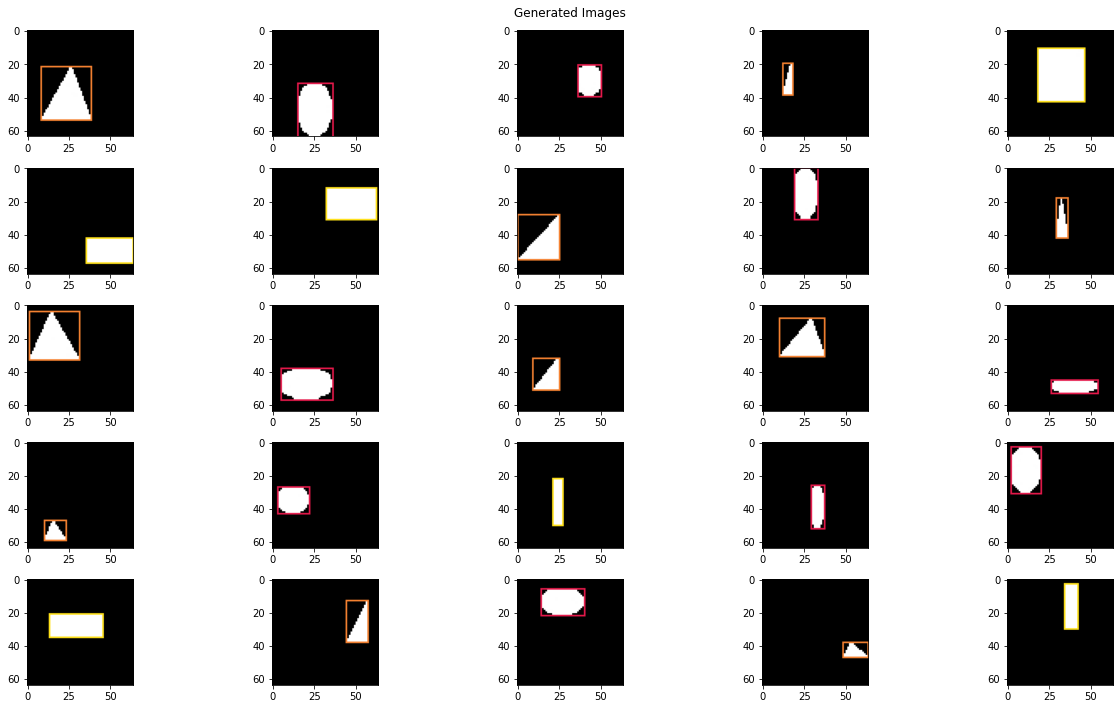

In [4]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_bboxes=True,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Generated Images")

## Train Object Localization Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them. 

Note:
1. For this model we need to output bounding boxes. We can do it by using the `B` output schema.
2. The number of detecting objects is 1.

In [3]:
ds_train, train_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_train", 
    output_schema = "B",
    num_detecting_objects=1,
)
print(
    "Training steps per epoch (for the default batch size 32):",
    train_steps_per_epoch
)

ds_val, val_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_val", 
    output_schema = "B",
    num_detecting_objects=1,
)
print(
    "Validation steps per epoch (for the default batch size 32):",
    val_steps_per_epoch
)

Training steps per epoch (for the default batch size 32): 219
Validation steps per epoch (for the default batch size 32): 63


Let's define a simple convolution model.

In [4]:
model = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
	tf.keras.layers.Dense(
		4,
		activation='relu')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.MeanAbsoluteError(),
)

Now we are ready to perform the model training. Note that the best model weights are stored in the `best_weights.h5` file.Train the model.Train the model.

In [5]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_weights.h5",
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=10,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    callbacks=checkpoint_callback,
    verbose=1
)

Epoch 1/10


2022-02-20 22:50:56.931252: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-20 22:50:57.480456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


219/219 [==============================] - ETA: 0s - loss: 4.1632
Epoch 1: val_loss improved from inf to 2.34210, saving model to best_weights.h5
219/219 [==============================] - 8s 28ms/step - loss: 4.1632 - val_loss: 2.3421
Epoch 2/10
218/219 [============================>.] - ETA: 0s - loss: 1.8337
Epoch 2: val_loss improved from 2.34210 to 1.50156, saving model to best_weights.h5
219/219 [==============================] - 7s 32ms/step - loss: 1.8314 - val_loss: 1.5016
Epoch 3/10
217/219 [============================>.] - ETA: 0s - loss: 1.3475
Epoch 3: val_loss improved from 1.50156 to 1.39639, saving model to best_weights.h5
219/219 [==============================] - 6s 30ms/step - loss: 1.3465 - val_loss: 1.3964
Epoch 4/10
217/219 [============================>.] - ETA: 0s - loss: 1.1227
Epoch 4: val_loss improved from 1.39639 to 1.08943, saving model to best_weights.h5
219/219 [==============================] - 7s 32ms/step - loss: 1.1213 - val_loss: 1.0894
Epoch 5/10


## Test Object Localization Model

Let's test the model on the unseen data.

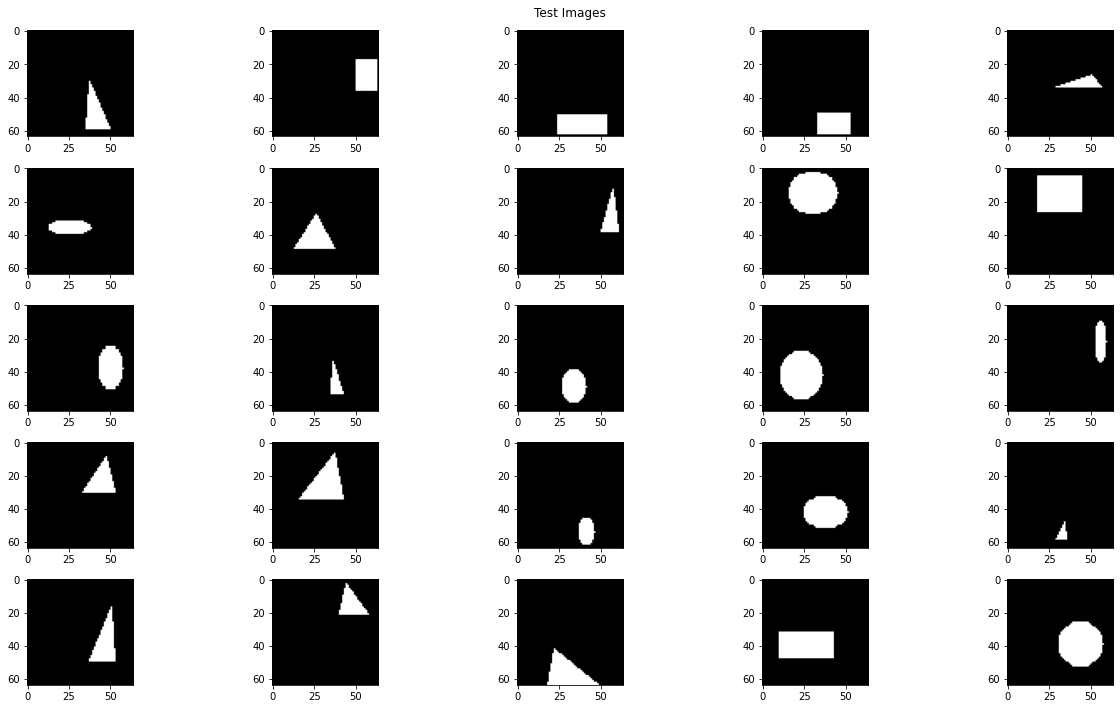

In [9]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Test Images")

Make model prediction and overlay results on the test images.

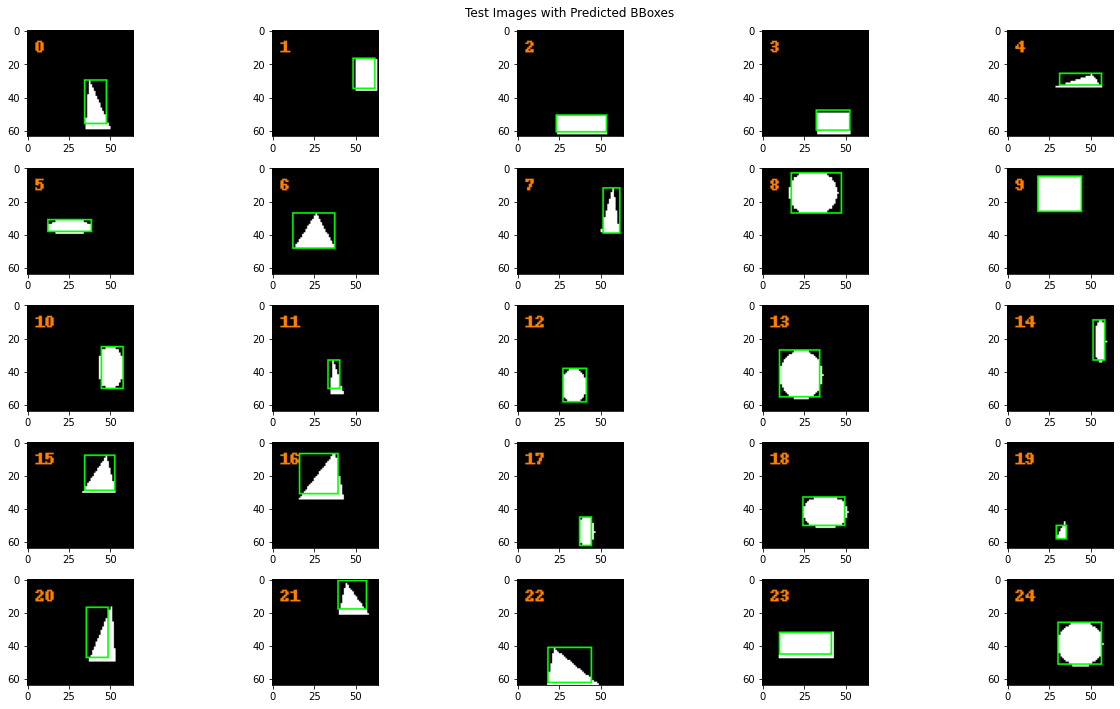

In [10]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

model.load_weights("best_weights.h5")
predictions = model.predict(preprocessed_images)

sample = 0
for image, prediction in zip(images, predictions):
    draw = ImageDraw.Draw(image)
    bbox = prediction.astype(int)

    x, y, w, h = bbox
    draw.rectangle(
        (x, y, x + w, y + h),
        outline="#00FF00"
    )

    draw.text(
        (5,5),
        str(sample),
        "#FF8000",
        font=ImageFont.load_default(),
    )
    sample += 1

plot_images(images, "Test Images with Predicted BBoxes")